In [5]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from wbfm.utils.projects.finished_project_data import ProjectData
import napari
import os
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fname = "/scratch/zimmer/Charles/dlc_stacks/worm3-tracklet_wiggle/project_config.yaml"

project_data = ProjectData.load_final_project_data_from_config(fname)

Project data for directory:
/scratch/zimmer/Charles/dlc_stacks/worm3-tracklet_wiggle 
Found the following raw data files:
red_data: True
green_data: True
============Segmentation===============
raw_segmentation: True
segmentation: True
============Tracklets==================
df_training_tracklets: True
reindexed_masks_training: True
============Traces=====================
red_traces: True
green_traces: True
final_tracks: True
behavior_annotations: True



In [85]:
from wbfm.utils.visualization.filtering_traces import remove_outliers_via_rolling_mean, filter_linear_interpolation
from wbfm.utils.projects.utils_neuron_names import int2name
from sklearn.impute import SimpleImputer

tracked_ind = [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 21, 26, 30, 31, 32, 33, 34, 35, 39, 41, 42, 43, 44, 45, 46, 47, 49, 53, 55, 56, 61, 62, 71, 72, 75, 79, 82, 84, 86, 95]
# Remove some that have extremely strong bleaching
# tracked_ind = [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 21, 26, 30, 31, 32, 33, 34, 35, 39, 41, 42, 43, 44, 45, 46, 47, 53, 55, 56, 61, 62, 71, 72, 75, 79, 82, 84, 86, 95]
tracked_names = [int2name(i) for i in tracked_ind]

f0 = lambda name: project_data.calculate_traces('ratio', 'integration', name)[1]
f1 = lambda X: remove_outliers_via_rolling_mean(X, 7, 0.1)
f2 = lambda X: filter_linear_interpolation(X)
f3 = lambda X: SimpleImputer().fit_transform(np.vstack(X))

X = [f3(f2(f2(f1(f0(n))))) for n in tracked_names]
X = np.hstack(X)

In [86]:
pca = PCA(n_components=10, whiten=False)
pca.fit(X)

X_proj = pca.transform(X)

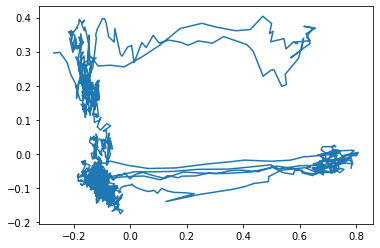

In [87]:

plt.plot(X_proj[:, 0], X_proj[:, 1])

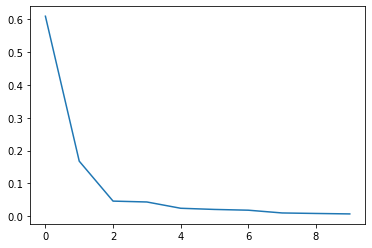

In [88]:
plt.plot(pca.explained_variance_ratio_)

In [89]:
bh = project_data.behavior_annotations
np.unique(bh)

array([0, 1, 2])

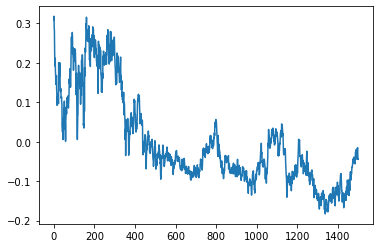

In [81]:
plt.plot(X_proj[:, 1])

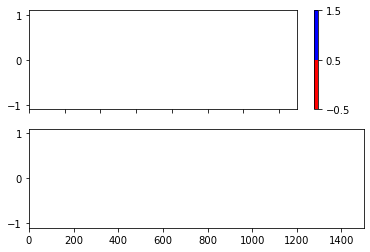

In [124]:
X0 = X_proj[:1498, [0]]
colored_segments = np.stack([X0, np.expand_dims(np.array(bh), axis=1)], axis=2)

cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)
lc = LineCollection(colored_segments, cmap=cmap, norm=norm)
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

lc.set_array(np.squeeze(X0))
lc.set_linewidth(2)

line = axs[0].add_collection(lc)
axs[0].set_xlim(0, 1500)
axs[0].set_ylim(-1.1, 1.1)
fig.colorbar(line, ax=axs[0])

plt.show()


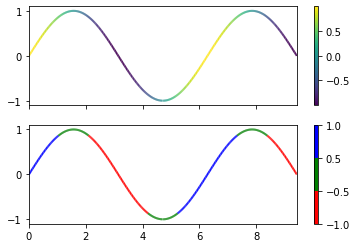

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

x = np.linspace(0, 3 * np.pi, 500)
y = np.sin(x)
dydx = np.cos(0.5 * (x[:-1] + x[1:]))  # first derivative

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[0].add_collection(lc)
fig.colorbar(line, ax=axs[0])

# Use a boundary norm instead
cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[1].add_collection(lc)
fig.colorbar(line, ax=axs[1])

axs[0].set_xlim(x.min(), x.max())
axs[0].set_ylim(-1.1, 1.1)
plt.show()


In [122]:
lc

AttributeError: 'BoundaryNorm' object has no attribute 'shape'

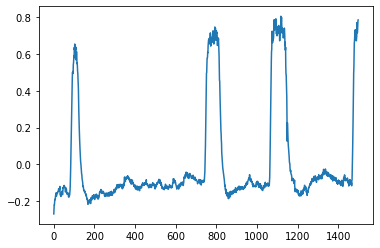

In [125]:
plt.plot(X0)